In [6]:
# data: https://download.pytorch.org/tutorial/data.zip
import string
import unicodedata
import glob
import io
import os
import torch
import random

# alphabets small  + capital letters + .,;'"
ALL_LETTERS = string.ascii_letters + " .,;"
N_LETTERS = len(ALL_LETTERS)

# Turn a unicode string in to plane ASCII
def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn' and c in ALL_LETTERS
  )

def load_data():
  # build the category lines dictionary , a list of names per language
  category_lines = {}
  all_categories = []

  def find_files(path):
    return glob.glob(path) # find all files in this specified directory

  # Read a file and split in to lines
  def read_lines(filename):
    lines = io.open(filename, encoding='utf-8').read().strip().split('\n') # open the file, read the entire contents as single string , remove any leading or trailing white spaces, splits  the string in to a list of lines based on '\n'
    return [unicode_to_ascii(line) for line in lines]

  for filename in find_files('/content/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)

    lines = read_lines(filename)
    category_lines[category] = lines

  return category_lines, all_categories

''' to represent a single letter , we use "one hot vector" of size <1 x n_letters>
    to make a word , we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>
    that extra 1 dimension is because Pytorch assumes everything is in batches, here batch size =1
'''


def letter_to_index(letter):
  return ALL_LETTERS.find(letter) # return the index of the letter in the ALL LETTERS

# Turn a line in to <line_length x 1 x n_letters>, or an array of one hot letter vectors

def line_to_tensor(line):
  tensor = torch.zeros(len(line), 1, N_LETTERS)
  for i , letter in enumerate(line):
    tensor[i][0][letter_to_index(letter)] = 1
  return tensor

def random_training_example(category_lines, all_categories):

  def random_choice(a):
    random_idx = random.randint(0, len(a)-1)
    return a[random_idx]

  category = random_choice(all_categories)
  line = random_choice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) # convert into 1D tensor
  line_tensor = line_to_tensor(line)
  return category, line, category_tensor, line_tensor

print(ALL_LETTERS)
print(unicode_to_ascii('Ślusàrski'))

category_lines, all_categories = load_data()
print(category_lines['Italian'][:5])

print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
torch.Size([5, 1, 56])


Name classification using RNN


In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

class RNN(nn.Module):
  def __init__(self,input_size, hidden_size, output_size) -> None:
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2h = nn.Linear(hidden_size + hidden_size, hidden_size )
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self,input_tensor, hidden_tensor , hidden_1):
    combined = torch.cat((input_tensor, hidden_tensor),dim=1)
    hidden = F.tanh(self.i2h(combined))
    combined_1 = torch.cat((hidden, hidden_1), dim=1)
    hidden_1 = F.tanh(self.h2h(combined_1))
    output = self.h2o(hidden_1)
    output = self.softmax(output)
    return output, hidden , hidden_1

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden , n_categories)

# #one step
# input_tensor = letter_to_tensor('A')
# hidden_tensor = rnn.init_hidden()

# output , next_hidden = rnn(input_tensor, hidden_tensor)
# # print(output.size())
# # print(next_hidden.size())

# # whole sequence/name
# input_tensor = line_to_tensor('Albert')
# hidden_tensor = rnn.init_hidden()
# output , next_hidden = rnn(input_tensor[0], hidden_tensor)
# print(output.size())
# print(next_hidden.size())

def category_from_output(output):
  category_idx = torch.argmax(output).item()
  return all_categories[category_idx]
#print(category_from_output(output))

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

def train(line_tensor, category_tensor):
  hidden = rnn.init_hidden()
  hidden_1 = rnn.init_hidden()
  for i in range(line_tensor.size()[0]):
    output , hidden ,hidden_1= rnn(line_tensor[i], hidden, hidden_1)

  loss = criterion(output, category_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000,5000
n_iters= 100000

for i in range(n_iters):
  category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

  output , loss  = train(line_tensor, category_tensor)
  current_loss+=loss

  if (i+1) % plot_steps ==0:
    all_losses.append(current_loss / plot_steps) #average
    current_loss= 0

  if (i+1)% print_steps==0:
    guess = category_from_output(output)
    correct = "CORRECT" if guess == category else f"WRONG ({category})"
    print(f'{i} {i/n_iters*100} {loss:.4f} {line}/ {guess} {correct}')

def predict(input_line):
  print(f'\n> {input_line}')
  with torch.no_grad():
    line_tensor = line_to_tensor(input_line)
    hidden = rnn.init_hidden()
    hidden_1 = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
      output , hidden ,hidden_1 = rnn(line_tensor[i], hidden, hidden_1)

    guess = category_from_output(output)
    print(guess)


4999 4.999 2.7139 Chuvyrov/ Greek WRONG (Russian)
9999 9.998999999999999 2.0013 Hoang/ German WRONG (Vietnamese)
14999 14.999 1.1079 Riagain/ Irish CORRECT
19999 19.999 2.0889 Reyes/ Portuguese WRONG (Spanish)
24999 24.999 3.2912 Oconnor/ German WRONG (English)
29999 29.999 0.8959 Ri/ Korean CORRECT
34999 34.999 1.1181 Mackenzie/ Scottish CORRECT
39999 39.999 1.8369 Collier/ French WRONG (English)
44999 44.999 3.1060 Jefferies/ Portuguese WRONG (English)
49999 49.999 2.7989 Nobbs/ Arabic WRONG (English)
54999 54.998999999999995 1.0653 Spano/ Spanish WRONG (Italian)
59999 59.999 1.6211 Nijo/ Korean WRONG (Japanese)
64999 64.999 1.7471 Walter/ Scottish WRONG (English)
69999 69.999 0.2154 Kouros/ Greek CORRECT
74999 74.99900000000001 0.0226 Slaski/ Polish CORRECT
79999 79.999 1.3767 Mai/ Chinese WRONG (Vietnamese)
84999 84.999 0.0024 Brisimitzakis/ Greek CORRECT
89999 89.999 0.2050 Cvacek/ Czech CORRECT
94999 94.999 1.1495 Peatain/ French WRONG (Irish)
99999 99.99900000000001 0.0023 Pham/

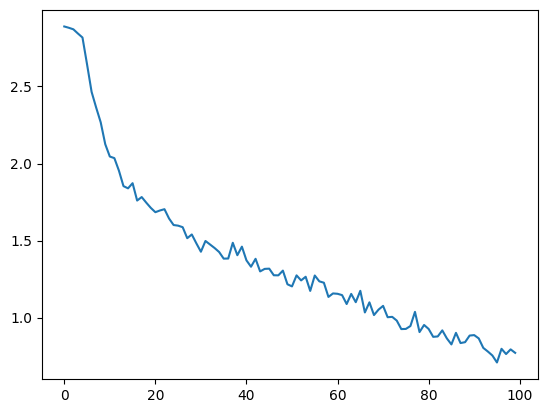

In [17]:
plt.figure()
plt.plot(all_losses)
plt.show()


In [18]:

while True:
  sentence = input("Input:")
  if sentence.lower() == "quit":
    break
  predict(sentence)

Input:Abbas

> Abbas
Arabic
Input:Khoury

> Khoury
Arabic
Input:Gerges

> Gerges
English
Input:Ajdrna

> Ajdrna
Czech
Input:Benesch

> Benesch
Czech
Input:Bock

> Bock
German
Input:Chi

> Chi
Chinese
Input:Smith

> Smith
Scottish
Input:Duncan

> Duncan
French
Input:Walker

> Walker
Scottish
Input:Alexandropoulos

> Alexandropoulos
Greek
Input:Avgerinos

> Avgerinos
Greek
Input:Belesis

> Belesis
Greek
Input:Adamidis

> Adamidis
Greek
Input:Adam

> Adam
Arabic
Input:Bran

> Bran
Irish
Input:Callaghan

> Callaghan
Irish
Input:Brady

> Brady
Irish
Input:Ceallachan

> Ceallachan
Irish
Input:Mohammed

> Mohammed
Arabic
Input:Jazeel

> Jazeel
Polish
Input:Jaseel

> Jaseel
French
Input:Ashique

> Ashique
French
Input:Noah

> Noah
Vietnamese
Input:Ibrahim

> Ibrahim
Russian
Input:John

> John
Irish
Input:Aodha

> Aodha
Arabic
Input:Clark

> Clark
English
Input:Cassidy

> Cassidy
Irish
Input:quit
